In [ ]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from google.colab import drive



In [ ]:
#подгружаем датасет
drive.mount("/content/drive", force_remount=True)

# представляем данные при помощи pandas
path = "/content/drive/MyDrive/data/Amazon_Unlocked_Mobile.csv"
reviews_df = pd.read_csv(path)
reviews_df.head(2)

Mounted at /content/drive


,Product Name,Brand Name,Price,Rating,Reviews
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu..."


# Подготовка данных для обучения

In [ ]:
#"рабочий" датасет
data = reviews_df.copy()

In [ ]:
#Показ датасета
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413840 entries, 0 to 413839
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Product Name  413840 non-null  object 
 1   Brand Name    348669 non-null  object 
 2   Price         407907 non-null  float64
 3   Rating        413840 non-null  int64  
 4   Reviews       413778 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 15.8+ MB


Проверим, что в датасете нет отзывов, которые не содержат текста отзыва или оценки, так как эти отзывы не несут для модели смысловой нагрузки.


In [ ]:
#Проверка на пустые отзывы
data['Reviews'].isnull().values.any()
data = data[data['Reviews'].notna()]
print('Отзывы:  ',data['Reviews'].isnull().values.any())

Отзывы:   False


In [ ]:
#Проверка на пустые оценки
print('Рейтинг:  ',data['Rating'].isnull().values.any())

Рейтинг:   False


In [ ]:
# вывод "проверенного" датасета
df=data[['Reviews','Rating']]
df


,Reviews,Rating
0,I feel so LUCKY to have found this used (phone...,5
1,"nice phone, nice up grade from my pantach revu...",4
2,Very pleased,5
3,It works good but it goes slow sometimes but i...,4
4,Great phone to replace my lost phone. The only...,4
...,...,...
413835,another great deal great price,5
413836,Ok,3
413837,Passes every drop test onto porcelain tile!,5
413838,I returned it because it did not meet my needs...,3


Изобразим соотношение раззличных оценок в датасете и укажем их количество.

In [ ]:
# соотношение различных оценок
df['Rating'].value_counts()

5    223580
1     72337
4     61374
3     31763
2     24724
Name: Rating, dtype: int64

Text(0, 0.5, 'Количество')

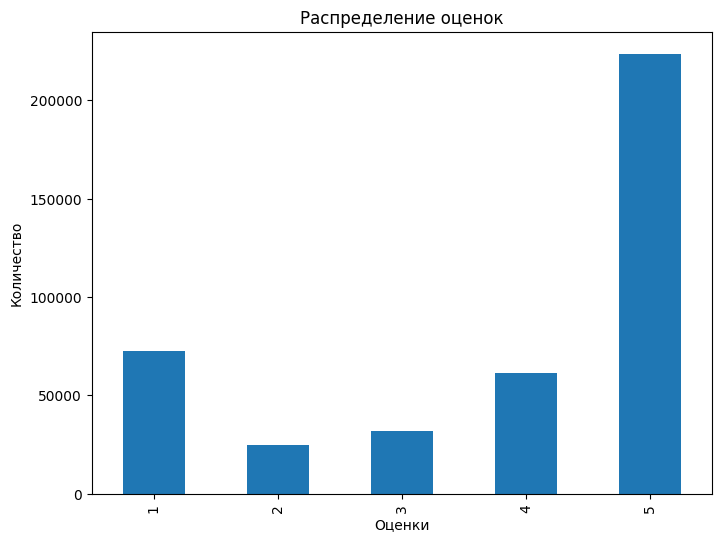

In [ ]:
plt.figure(figsize=(8,6))
df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Распределение оценок')
plt.xlabel('Оценки')
plt.ylabel('Количество')


 Укажем, что является положительным, а что отрицательным отзывом, а также проведем балансировку датасета для грамотного обучения модели.

In [ ]:
df['Rating']=df['Rating'].astype(int) #делим рейтинг на "положительный" и "отрицательный"

df['label']=np.where(df['Rating']>=4,1,0) #1-Positive,0-Negative


<ipython-input-10-34e0b8ff3849>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rating']=df['Rating'].astype(int) #делим рейтинг на "положительный" и "отрицательный"
<ipython-input-10-34e0b8ff3849>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label']=np.where(df['Rating']>=4,1,0) #1-Positive,0-Negative


In [ ]:
#Делаем balanced dataset
df = df.sample(frac=1).reset_index(drop=True) #перемешиваем данные для случайности обучения
data=df[df['label']==0][:50000]
data=data.append(df[df['label']==1][:50000])
data = data.reset_index(drop=True)
display(data['label'].value_counts())
data

<ipython-input-11-d303ac716c3a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data=data.append(df[df['label']==1][:50000])


0    50000
1    50000
Name: label, dtype: int64

,Reviews,Rating,label
0,"The most horribly unresponsive, slow, annoying...",1,0
1,A barely usable flip phone. Has poor features....,2,0
2,"Very bad quality, is really slow and drop call...",1,0
3,The phone was popped out they did not seem to ...,1,0
4,This phone is powerfull and very easy to use a...,3,0
...,...,...,...
99995,This is a nice phone with all the basic featur...,4,1
99996,"Excellent! Absolutely new XT1095, very beautif...",5,1
99997,excelent,5,1
99998,Works perfectly! Would purchase again from thi...,5,1


Далее нужно создать набор данных в удобном формате, чтобы можно было работать с данными напрямую. Потом, как и в любой задаче NLP, необходимым процессом является преобразование текста в вид, который методы машинного обучения могут считывать. А также формирование  данных в удобный для человека формат, чтобы можно было легко работать с ними.


In [ ]:
data['pre_process'] = data['Reviews'].apply(lambda x: ' '.join(x.lower() for x in str(x).split())) # уменьшает регистр и оставляет слова через пробелы

data['pre_process']=data['pre_process'].apply(lambda x: re.sub(r'http\S+', '', x)) # убирает возможное число ссылок


In [ ]:
def contractions(s):  # убираем сокращения
 s = re.sub(r"won't", "will not",s)
 s = re.sub(r"would't", "would not",s)
 s = re.sub(r"could't", "could not",s)
 s = re.sub(r"\'d", "would",s)
 s = re.sub(r"can\’t", "can not",s)
 s = re.sub(r"n\'t", " not", s)
 s= re.sub(r"\'re", "are", s)
 s = re.sub(r"\'s", "is", s)
 s = re.sub(r"\'ll", " will", s)
 s = re.sub(r"\t", " not", s)
 s = re.sub(r"\'ve", "have", s)
 s = re.sub(r"\'m", "am", s)
 return s
data['pre_process']=data['pre_process'].apply(lambda x:contractions(x))


In [ ]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [ ]:
data['pre_process']=data['pre_process'].apply(lambda x: ' '.join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))

data['pre_process']=data['pre_process'].apply(lambda x: re.sub(' +', ' ', x))

# удаляем стоп-слова
from nltk.corpus import stopwords
stop = stopwords.words('english')
data['pre_process']=data['pre_process'].apply(lambda x: ' '.join([x for x in x.split() if x not in stop]))

# лемматизируем
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
data['pre_process']=data['pre_process'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))


In [ ]:
# смотрим, что получилось после лемматизации и исключения стоп-слов
data

,Reviews,Rating,label,pre_process
0,"The most horribly unresponsive, slow, annoying...",1,0,horribly unresponsive slow annoying useless ph...
1,A barely usable flip phone. Has poor features....,2,0,barely usable flip phone poor feature get bett...
2,"Very bad quality, is really slow and drop call...",1,0,bad quality really slow drop call sim card
3,The phone was popped out they did not seem to ...,1,0,phone popped seem new scratch glass expected g...
4,This phone is powerfull and very easy to use a...,3,0,phone powerfull easy use configure deffect spa...
...,...,...,...,...
99995,This is a nice phone with all the basic featur...,4,1,nice phone basic feature one expects smart pho...
99996,"Excellent! Absolutely new XT1095, very beautif...",5,1,excellent absolutely new xt beautiful bamboo b...
99997,excelent,5,1,excelent
99998,Works perfectly! Would purchase again from thi...,5,1,work perfectly would purchase vendor


## Подготовка к обучению модели

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train, Y_test = train_test_split(data['pre_process'], data['label'], test_size=0.25, random_state=30)
print('Train: ',X_train.shape,Y_train.shape,'Test: ',(X_test.shape,Y_test.shape))

Train:  (75000,) (75000,) Test:  ((25000,), (25000,))


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer= TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)


In [ ]:
import warnings
warnings.filterwarnings("ignore")

Для определения тональности будут использованы три метода машинного обучения: SVM, Random Forest и логистическая регресссия


# Подготовка гиперпараметров для каждой модели




In [ ]:
# подготовка гиперпараметров для логистической регрессии
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l2","none"]}# тип регуляризации может быть L1 (лассо) или L2 (гребневая)
logreg=LogisticRegression(solver="lbfgs")
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(tf_x_train, Y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
accuracy : 0.8913733333333334


In [ ]:
from sklearn.svm import SVC
param_grid = {'C': [0.1, 1],
              'gamma': [1, 0.1],
              'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,cv=3)

grid.fit(tf_x_train, Y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.862 total time=10.0min
[CV 2/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.864 total time=10.9min
[CV 3/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.864 total time=10.2min
[CV 1/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.837 total time=10.5min
[CV 2/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.836 total time=10.8min
[CV 3/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.838 total time=11.1min
[CV 1/3] END ..........C=1, gamma=1, kernel=rbf;, score=0.905 total time=18.4min
[CV 2/3] END ..........C=1, gamma=1, kernel=rbf;, score=0.906 total time=18.4min
[CV 3/3] END ..........C=1, gamma=1, kernel=rbf;, score=0.906 total time=18.6min
[CV 1/3] END ........C=1, gamma=0.1, kernel=rbf;, score=0.878 total time= 8.7min
[CV 2/3] END ........C=1, gamma=0.1, kernel=rbf;, score=0.880 total time= 9.3min
[CV 3/3] END ........C=1, gamma=0.1, kernel=rbf;,

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.1, 1], 'gamma': [1, 0.1], 'kernel': ['rbf']},
             verbose=3)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope

from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials

def hyperparameter_tuning(params):
    clf = RandomForestClassifier(**params,n_jobs=-1)
    acc = cross_val_score(clf, tf_x_train,Y_train,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}


# Анализ тональности

В работе произведен анализ тональности при помощи четырех методов машинного обучения: логистической регрессии, метода опорных векторов, метода случайного леса и полиномиального байесовского классификатора.

### Логистическая регрессия

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000,C=10, penalty='l2', solver='liblinear')

In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from scikitplot.metrics import plot_confusion_matrix

In [ ]:
logreg.fit(tf_x_train,Y_train)

LogisticRegression(C=10, max_iter=1000, solver='liblinear')

In [ ]:
y_test_pred=logreg.predict(tf_x_test)

Accuracy_score:  0.88832
Precision_score:  0.895662175484719
Recall_score:  0.8774951706374758
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     12576
           1       0.90      0.88      0.89     12424

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



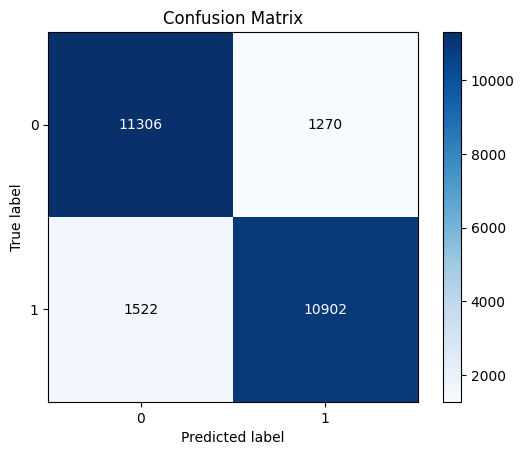

In [ ]:
# матрица и метрики ошибок
plot_confusion_matrix(Y_test,y_test_pred)
acc_score = accuracy_score(Y_test,y_test_pred)
pre_score = precision_score(Y_test,y_test_pred)
rec_score = recall_score(Y_test,y_test_pred)
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print("-"*50)
cr = classification_report(Y_test,y_test_pred)
print(cr)

# Метод опорных векторов

In [ ]:
from sklearn.svm import SVC
clf = SVC(C=1, gamma=1)
clf.fit(tf_x_train,Y_train)

test_pred=clf.predict(tf_x_test)


Accuracy_score:  0.91288
Precision_score:  0.912214354682974
Recall_score:  0.9125080489375402
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     12576
           1       0.91      0.91      0.91     12424

    accuracy                           0.91     25000
   macro avg       0.91      0.91      0.91     25000
weighted avg       0.91      0.91      0.91     25000



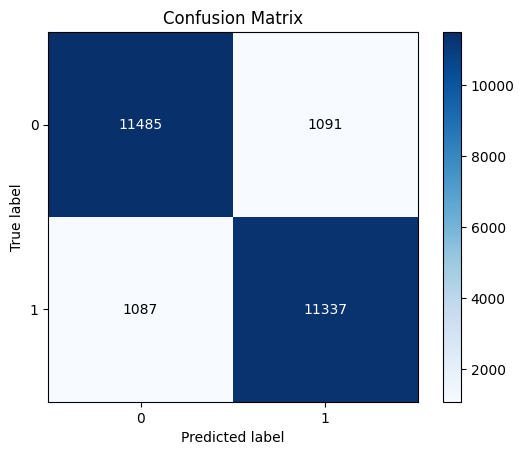

In [ ]:
# матрица и метрики ошибок
plot_confusion_matrix(Y_test,test_pred)
acc_score = accuracy_score(Y_test,test_pred)
pre_score = precision_score(Y_test,test_pred)
rec_score = recall_score(Y_test,test_pred)
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print("-"*50)
cr = classification_report(Y_test,test_pred)
print(cr)

## Полиномиальный наивный байесовский классификатор

In [ ]:

from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(tf_x_train,Y_train)

MultinomialNB()

Accuracy_score:  0.86304
Precision_score:  0.8814205797592812
Recall_score:  0.8370090148100451
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.89      0.87     12576
           1       0.88      0.84      0.86     12424

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



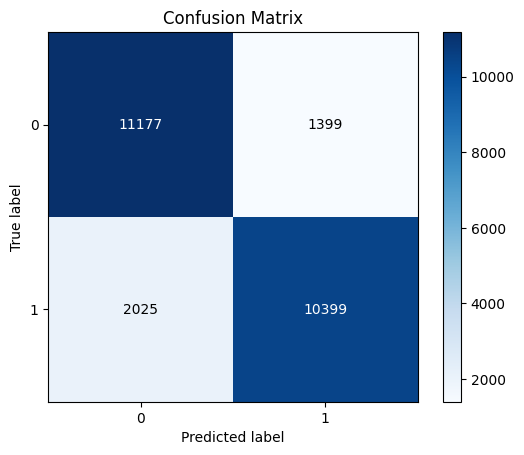

In [ ]:
predictions = nb.predict(tf_x_test)

plot_confusion_matrix(Y_test,predictions)
acc_score = accuracy_score(Y_test,predictions)
pre_score = precision_score(Y_test,predictions)
rec_score = recall_score(Y_test,predictions)
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print("-"*50)
cr = classification_report(Y_test,predictions)
print(cr)

## Метод случайного леса

In [ ]:
rfc=RandomForestClassifier(criterion= 'gini', max_depth= 15, n_estimators= 200)

rfc.fit(tf_x_train,Y_train)
predictions = rfc.predict(tf_x_test)

Accuracy_score:  0.77976
Precision_score:  0.7372427983539095
Recall_score:  0.8651802962009015
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.70      0.76     12576
           1       0.74      0.87      0.80     12424

    accuracy                           0.78     25000
   macro avg       0.79      0.78      0.78     25000
weighted avg       0.79      0.78      0.78     25000



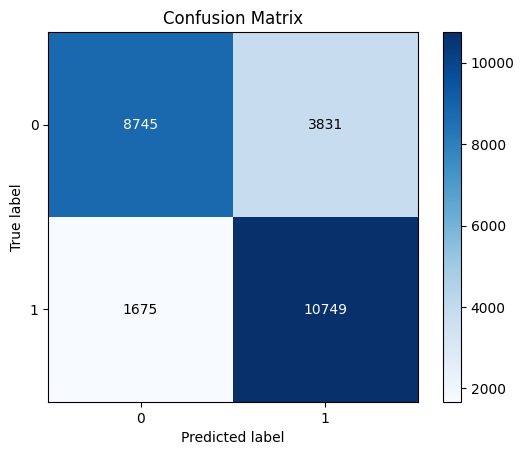

In [ ]:
plot_confusion_matrix(Y_test,predictions)
acc_score = accuracy_score(Y_test,predictions)
pre_score = precision_score(Y_test,predictions)
rec_score = recall_score(Y_test,predictions)
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print("-"*50)
cr = classification_report(Y_test,predictions)
print(cr)

# Определение тональности отзыва, введенного пользователем

In [ ]:
def text_transformation(input): # подготовка текста: нижний регистр, лемматизация
    corpus = []
    for item in input:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lemmatizer.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [ ]:
def expression_check(prediction_input): # вспомогательная функция вывода
    if 0 in prediction_input:
        print("Введенное высказывание имеет отрицательную тональность.")
    elif 1 in prediction_input:
        print("Введенное высказывание имеет положительную тональность.")
    else:
        print("Ошибка при обработке.")

In [ ]:
def sentiment_predict(input):  # определение тональности введенного отзыва при помощи метода опорных векторов
    input = text_transformation(input)
    transformed_input = vectorizer.transform(input)
    prediction = clf.predict(transformed_input)
    expression_check(prediction)
    return prediction


In [ ]:
review = [" This phone is bad! I am absolutely unpleasant! The main thing is impractical screen.."]
sentiment_predict(review)

Введенное высказывание имеет отрицательную тональность.


array([0])

In [ ]:
# Эксперименты, указанные в курсовой работе
# This phone is bad! I am absolutely unpleasant! The main thing is impractical screen.
# This phone is goodness ! I am absolutely pleasant ! The main thing is practical screen .
# Phone is absolutely useless and security police is not safe.
# This bad device has the ugliest screen, that I has ever seen in my life!
# Device is better, than anything I've seen in my life! Colours are beautiful and favorable.

Модификация отрицательных отзывов - повышение тональности`

In [ ]:
from nltk.corpus import wordnet
from nltk.corpus import sentiwordnet as swn
import csv

In [ ]:
def find_adjectives(words):
    tokens = words.split()
    tagged = nltk.pos_tag(tokens)
    adjectives = [word for word, pos in tagged if pos.startswith('JJ')]
    return adjectives

adjectives = []
data['pre_process'][::2].apply(lambda x: adjectives.extend(find_adjectives(x)))
print(adjectives)

['unresponsive', 'slow', 'inexcusable', 'bad', 'slow', 'easy', 'spanish', 'incredible', 'little', 'good', 'summary', 'incredible', 'android', 'applicable', 'good', 'free', 'good', 'smaller', 'portable', 'fit', 'standby', 'good', 'great', 'bad', 'main', 'reboot', 'several', 'iam', 'afraid', 'several', 'watch', 'able', 'common', 'older', 'incredible', 'much', 'main', 'gripe', 'smart', 'iam', 'little', 'much', 'sd', 'gb', 'sd', 'free', 'gb', 'internal', 'mb', 'mb', 'mean', 'low', 'new', 'larger', 'apps', 'sd', 'apps', 'free', 'low', 'overall', 'bad', 'adjust', 'low', 'short', 'good', 'incredible', 'poor', 'fast', 'quality', 'false', 'local', 'new', 'screen', 'nonresponsive', 'top', 'quick', 'unaccceptable', 'dont', 'unlocked', 'cant', 'refib', 'little', 'horrible', 'crappy', 'sync', 'let', 'possible', 'metro', 'miss', 'unable', 'sim', 'returned', 'full', 'poor', 'hold', 'return', 'screen', 'camera', 'new', 'fifty', 'iffy', 'previous', 'newer', 'cheaper', 'india', 'unlocked', 'unlocked', '

In [ ]:
def find_negative_words(adjectives):
    negative_words = []
    for word in adjectives:
        # получаем все синтетические наборы эмоциональных значений для текущего слова
        synsets = list(swn.senti_synsets(word))
        if synsets:
            # считаем среднюю оценку для всех синтетических наборов
            score = sum([synset.neg_score() for synset in synsets]) / len(synsets)
            if score > 0.5:
                negative_words.append(word)
        else:
            # если синтетических наборов не найдено, ищем все синсеты для текущего слова
            synsets = wordnet.synsets(word)
            for synset in synsets:
                for lemma in synset.lemmas():
                    if lemma.antonyms() and (lemma.antonyms()[0].name() == "good" or lemma.antonyms()[0].name() == "positive"):
                        negative_words.append(word)
                        break
    # выводим полученный словарь отрицательных слов для датасета отзывов
    negative_words = set(negative_words)
    return(negative_words)
neg_dict = find_negative_words(adjectives)
print(neg_dict)

{'unethical', 'indeterminable', 'incomprehensible', 'uneducated', 'lousiest', 'suspicious', 'lousy', 'paranoid', 'smudgy', 'unpleasant', 'unwilling', 'stereotypical', 'stressful', 'impractical', 'infrequent', 'unaccepted', 'pitiful', 'unmodified', 'unfavorable', 'awkward', 'inconvenienced', 'unoriginal', 'grimy', 'extrinsic', 'nonexistent', 'infamous', 'ugliness', 'filthy', 'unfortunate', 'unreliable', 'inconvenient', 'nonresistant', 'horrendous', 'misleading', 'horrible', 'unbearable', 'incredulous', 'inaccurate', 'unlucky', 'unconscionable', 'dismal', 'stubborn', 'bearable', 'unsafe', 'unmarked', 'foolishly', 'shoddy', 'harsh', 'troubled', 'mislead', 'clumsy', 'afraid', 'reprehensible', 'unimpressed', 'unholy', 'indignant', 'unfamiliar', 'protected', 'letdown', 'liar', 'obnoxious', 'unworkable', 'uncontrollable', 'unusable', 'untrue', 'undesirable', 'unbranded', 'unrealistic', 'wrong', 'outrageous', 'unanswered', 'troublesome', 'tricked', 'nontechnical', 'psychotic', 'unobtrusive', '

In [ ]:
def find_positive_words(adjectives):
    positive_words = []
    for word in adjectives:
        # получаем все синтетические наборы эмоциональных значений для текущего слова
        synsets = list(swn.senti_synsets(word))
        if synsets:
            # считаем среднюю оценку для всех синтетических наборов
            score = sum([synset.pos_score() for synset in synsets]) / len(synsets)
            if score > 0.5:
                positive_words.append(word)
        else:
            # если синтетических наборов не найдено, ищем все синсеты для текущего слова
            synsets = wordnet.synsets(word)
            for synset in synsets:
                for lemma in synset.lemmas():
                    if lemma.antonyms() and (lemma.antonyms()[0].name() == "bad" or lemma.antonyms()[0].name() == "negative"):
                        positive_words.append(word)
                        break
    # выводим полученный словарь отрицательных слов для датасета отзывов
    positive_words = set(positive_words)
    return(positive_words)

pos_dict = find_positive_words(adjectives)
print(pos_dict)

{'beautiful', 'credible', 'identifiable', 'optimistic', 'admirable', 'cheerful', 'trustful', 'luxurious', 'sexiest', 'discernable', 'pleasant', 'merciful', 'majestic', 'ludicrous', 'worthy', 'commendable', 'lucky', 'innovative', 'superb', 'integrity', 'tillable', 'better', 'healthy', 'nicest', 'mindful', 'printable', 'goodness', 'meticulous', 'loveable', 'pushy', 'excellent', 'valiant', 'beneficial', 'cute', 'nifty', 'adventurous', 'topnotch', 'amusing', 'favorable', 'evident', 'livable', 'happy', 'authentic', 'sexy', 'admire', 'playable', 'refurbishment', 'clever', 'competent', 'awesome', 'happiness', 'fortunate', 'replaceable', 'proud', 'vibrant', 'mild', 'honorable', 'courteous', 'upfront', 'splendid', 'delightful', 'mom', 'kudos', 'discernible', 'adoptable', 'best', 'hardcore', 'conspicuous', 'handsome', 'gracious', 'stealthy', 'nice', 'disrespectful', 'happier', 'laughable', 'chic', 'crucial', 'exhaustive', 'assertive', 'luckier', 'disillusioned', 'advisable', 'exchangeable', 'rec

In [ ]:
def find_antonyms(word):
    with open('aaa.txt', 'r', encoding='utf-8') as file:
        reader = csv.reader(file, delimiter='\t')
        for row in reader:
            if row[1] == word:
                return row[0]
            elif row[0] == word or row[2] == word:
                return row[1]
    return None

In [ ]:
def invert_tone(text, wordset, antonym_set):
    new_text = ""
    prev_word = ""
    skip_next_adjective = False
    for word in nltk.word_tokenize(text):
        if word.lower() in {"not", "n't", "never"}:
            prev_word = word
            skip_next_adjective = False
        elif prev_word and prev_word.lower() in {"am", "is", "are", "was", "were", "be", "been", "being", "has", ""}:
            prev_word = ""
            skip_next_adjective = True
        elif skip_next_adjective and pos_tag([word])[0][1] == "JJ":
            new_text += word + " "
            skip_next_adjective = False
        elif word in wordset:
            synsets = wordnet.synsets(word)
            if len(synsets) > 0:
                antonyms = set()
                for syn in synsets:
                    for lemma in syn.lemmas():
                        for antonym in lemma.antonyms():
                            antonyms.add(antonym.name())
                if len(antonyms) > 0:
                    found_antonym = False
                    for antonym in antonyms:
                        if antonym in antonym_set:
                            new_text += antonym + " "
                            found_antonym = True
                            break
                    if not found_antonym:
                        antonym = antonyms.pop()
                        new_text += antonym + " "
                else:
                    if find_antonyms(word) == None:
                      new_text += word+ " "
                    else:
                      new_text += find_antonyms(word)+ " "
            else:
                new_text += word + " "
        else:
            new_text += word + " "
    return new_text.strip()

In [ ]:
prediction = sentiment_predict(review)
if prediction == 0:
  print(review[0])
  new_text = invert_tone(review[0], neg_dict, pos_dict)
  print ('Выполним инвертирование тональности.')
  print(new_text)
  sentiment_predict(new_text)
elif prediction == 1:
  print(review[0])
  new_text = invert_tone(review[0], pos_dict, neg_dict)
  print(new_text)
  sentiment_predict(new_text)
else:
  print("Ошибка при обработке.")

Введенное высказывание имеет отрицательную тональность.
 This phone is bad! I am absolutely unpleasant! The main thing is impractical screen..
Выполним инвертирование тональности.
This phone is goodness ! I am absolutely pleasant ! The main thing is practical screen ..
Введенное высказывание имеет положительную тональность.
